# Expressibility of Quantum Neural Network

<em>Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.</em>

## Overview

In quantum machine learning, the **expressibility** of quantum neural networks is a crucial factor in quantum machine learning tasks. In general, the stronger the expressiveness of the proposed quantum neural network, the higher the likelihood that quantum machine learning can search for the global optimal solution. This tutorial first introduces the basic concept of the expressibility of quantum neural networks. Then we will show how to exhibit the difference in the expressibility of different ansatz through Bloch spheres in Paddle Quantum. Finally, a method for quantitatively analyzing the expressibility of quantum neural networks is introduced, and the expressibility of quantum neural network templates provided by Paddle Quantum is evaluated at different depths.

## Background

Let us first review the basic process of quantum machine learning algorithms. In quantum machine learning, we tend to design a loss function $\mathcal{L}$ and minimize the loss function by optimizing a unitary $U$

$$
\min_U\mathcal{L}(U)=\min_U \text{Tr}[HU\rho_{in}U^\dagger].\tag{1}
$$

The mathematical principle behind the algorithm guarantees that the minimum value that the loss function can take corresponds to the solution of our problem when we have traversed all possible unitaries. In practice, we use quantum neural networks to parameterize the unitaries as follows

$$
U=U(\vec{\theta})=U_D(\vec{\theta}_D)\dots U_1(\vec{\theta}_1),\tag{2}
$$

where each $U_j(\vec{\theta}_j),j\in[1,D]$ represents a layer of the quantum neural network, and $\vec{\theta}_j$ represents the parameters corresponding to that layer. At this point, by adjusting the parameters $\vec{\theta}$ in the quantum neural network, we can perform the optimization of the unitary $U$ and thus minimize the loss function $\mathcal{L}$.

$$
\min_{\vec{\theta}}\mathcal{L}(\vec{\theta})=\min_{\vec{\theta}} \text{Tr}[HU(\vec{\theta})\rho_{in}U(\vec{\theta})^\dagger].\tag{3}
$$

However, careful readers may have noticed a shortcoming of quantum neural networks at this point: for a given neural network fit, ** traversing all the parameters does not necessarily guarantee traversing all the unitaries**. As a simple example, if we allow only one $R_Y$ rotation gate as a single-qubit quantum neural network $U(\theta)=R_Y(\theta)$, it is clear that (up to a global phase) $U(\theta)$ cannot represent any complex unitary with the imaginary part of matrix elements. And when allowing the use of $R_Y$ and $R_Z$ revolving gates, if we build the quantum neural network as $U(\vec{\theta})=R_Z(\theta_1)R_Y(\theta_2)R_Z(\theta_3)$, $U(\vec{\theta})$ (up to a global phase) will be able to represent all the single-qubit unitaries [1].

If we define the expressibility of a neural network as **the number of unitaries that the circuit can express when traversing the circuit parameters $\vec{\theta}$**, then a quantum neural network with strong expressibility will be more likely to contain those unitaries that globally minimize the loss function $\mathcal{L}$; conversely, if a quantum neural network $U_{ weak}$ is so weak that it does not contain any unitary that minimize the loss function, then a quantum machine learning task based on optimizing $U_{weak}$ is likely to fail.

Next, we visualize the expressibility of quantum neural networks based on Paddle Quantum by looking at the ability of a single qubit to traverse the Bloch sphere through unitaries.

## Intuition: traversing the Bloch sphere

In the one qubit case, we can directly observe how a quantum neural network traverses the surface of a Bloch sphere with a fixed input. For a given neural network ansatz $U(\vec{\theta})$, since the input to the network tends to be fixed (we set it to $|0\rangle$), by uniformly sampling the neural network parameters $\vec{\theta}$, the output state of the neural network $U(\vec{\theta})|0\rangle$ will be scattered over the surface of the Bloch sphere. Obviously, if the output states are more widely and uniformly distributed on the surface of the sphere, the more expressive the neural network ansatz $U$ will be, and the more likely it will contain the global optimum of the loss function.

To implement this function in Paddle, we first import necessary packages.

In [1]:
import numpy as np
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.visual import plot_state_in_bloch_sphere

/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in 

First, we allow only one $R_Y$ rotation gate to construct quantum neural network $U(\theta)=R_Y(\theta)$. By uniformly sampling the parameter $\theta$ at $[0,2\pi]$ and acting $U(\theta)$ on a fixed input $|0\rangle$, we obtain the output distribution of the quantum neural network $U(\theta)$. With the built-in plot_bloch_sphere_from_input function of Paddle Quantum, we can directly observe the distribution of $U(\theta)|0\rangle$ on the Bloch sphere as follows.

In [2]:
num_qubit = 1      # the number of qubit
num_sample = 2000  # the number of sample
outputs_y = list()   # save QNN outputs

for _ in range(num_sample):
    # initialize QNN ansatz
    pq.set_backend('density_matrix')
    cir = Circuit(num_qubit)
    # apply Ry with a random rotating angle
    cir.ry(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_y.append(rho)
    
# built-in function of Paddle Quantum to plot on Bloch sphere
# plot_state_in_bloch_sphere(outputs_y, save_gif=True, filename='figures/bloch_y.gif')

/home/zl/miniconda3/envs/pq/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


![bloch_y.gif](./figures/expressibility-fig-bloch_y.gif)

It can be seen that the output of the quantum neural network $U(\theta)=R_Y(\theta)$ can only be distributed in a circle on the Bloch sphere (although the distribution is uniform over the circle). Similarly, we consider the neural network $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)$ with two parameters and the neural network $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$ with three parameters. The output distribution is:

In [3]:
outputs_yz = list()   # save QNN outputs
for _ in range(num_sample):
    # initialize QNN ansatz
    cir = Circuit(num_qubit)
    # apply Ry and Rz with random rotating angles
    cir.ry(0)
    cir.rz(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_yz.append(rho)

# plot_state_in_bloch_sphere(outputs_yz, save_gif=True, filename='figures/bloch_yz.gif')


outputs_yzy = list()   # save QNN outputs
for _ in range(num_sample):
    # initialize QNN ansatz
    cir = Circuit(num_qubit)
    # apply Ry, Rz, and Ry with random rotating angles
    cir.ry(0)
    cir.rz(0)
    cir.ry(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_yzy.append(rho)
    
# plot_state_in_bloch_sphere(outputs_yzy, save_gif=True, filename='figures/bloch_yzy.gif')

![bloch_yz.gif](./figures/expressibility-fig-bloch_yz.gif)

![bloch_yzy.gif](./figures/expressibility-fig-bloch_yzy.gif)

It can be seen that the output of the neural network $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)$ can be distributed over the entire surface of the Bloch sphere now, although the distribution is more concentrated near the two polars ($|0\rangle$ and $|1\rangle$); and the output of the neural network $U(\vec{\theta})=R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$ is more uniformly distributed over the surface of the sphere.

In the low-dimensional case of single qubit, we can qualitatively observe the expressibility of quantum neural networks with the help of Bloch spheres. In general situations with multiple qubits, we have to analyze the expressibility quantitatively via statistical mathematical tools. Next, we will introduce the K-L divergence of the fidelity distribution among quantum states to quantify the expressibility of a quantum neural network and calculate the expressibility of a commonly used ansatz.

## Quantitative analysis of expressibility by the K-L divergence

### Fidelity distribution and the K-L divergence

In [2], the authors proposed a method for quantifying the expressive power based on the probability distribution of fidelity between the output states of a quantum neural network. For any quantum neural network $U(\vec{\theta})$, sampling the neural network parameters twice (let them be $\vec{\phi}$ and $\vec{\psi}$), the fidelity $F=|\langle0|U(\vec{\phi})^\dagger U(\vec{\psi}) |0\rangle|^2$ subjects to some probability distribution
$$
F\sim{P}(f).\tag{4}
$$
According to [2], when a quantum neural network $U$ can uniformly represent unitaries (now we call that $U$ subjects to the Haar measure), the probability distribution of fidelity $P_\text{Haar}(f)$ satisfies
$$
P_\text{Haar}(f)=(2^{n}-1)(1-f)^{2^n-2}.\tag{5}
$$

Paddle Quantum provides functions that sample unitaries from the Haar measure. We evaluate the probability distribution that the fidelity of the outputs of the Haar random unitaries subjects to:

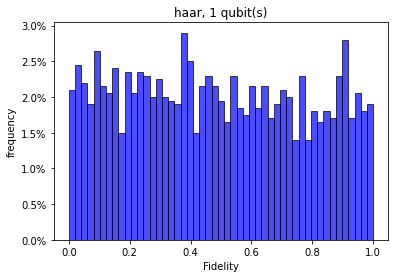

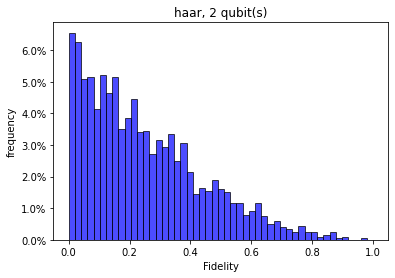

In [4]:
from paddle_quantum.linalg import haar_unitary
from paddle_quantum.qinfo import state_fidelity
from paddle_quantum.state.common import to_state
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import integrate

# plot histgram
def plot_hist(data, num_bin, title_str):
    def to_percent(y, position):
        return str(np.around(y*100, decimals=2)) + '%'
    plt.hist(data, weights=[1./len(data)]*len(data), bins=np.linspace(0, 1, num=num_bin), facecolor="blue", edgecolor="black", alpha=0.7)
    plt.xlabel("Fidelity")
    plt.ylabel("frequency")
    plt.title(title_str)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()
    
    
# evaluate the probability distribution of F generated by a Haar random unitary
def p_F_haar(n, s, b=50, draw=False):
    f_list = list()
    # sampling
    for i in range(s):
        # sample a unitary
        u1 = haar_unitary(n)
        # the output of u1
        phi1 = u1[:,0]
        rho1 = to_state(np.outer(phi1, phi1.conj()))
        # sample a unitary
        u2 = haar_unitary(n)
        phi2 = u2[:,0]
        # the output of u2
        rho2 = to_state(np.outer(phi2, phi2.conj()))
        # compute fidality
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    # plot histgram
    if draw:
        title_str = "haar, %d qubit(s)" % num_qubit
        plot_hist(f_list, b, title_str)
    sample_distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    # compute a theoretical distribution
    theory_distribution = np.zeros_like(sample_distribution)
    for index in range(len(theory_distribution)):
        def p_continues(f):
            return (2 ** n - 1) * (1 - f) ** (2 ** n - 2)
        lower = 1/b*index
        upper = lower + 1/b
        theory_distribution[index], _ = integrate.quad(p_continues,lower,upper)
    return sample_distribution, theory_distribution


num_qubit = 1
p_haar_1qubit, theory_haar_1qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 2
p_haar_2qubit, theory_haar_2qubit = p_F_haar(num_qubit, num_sample, draw=True)

It can be seen that the fidelity distribution roughly obeys $P_\text{Haar}$. Similarly, we can compute the probability distributions of the fidelity of the outputs of the previously defined single-qubit quantum neural networks $R_Y(\theta)$, $R_Y(\theta_1)R_Z(\theta_2)$ and $R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$.

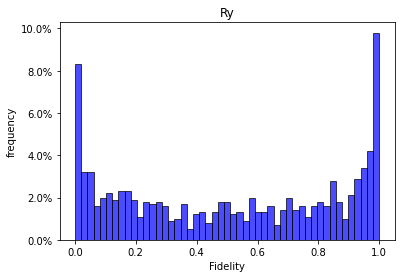

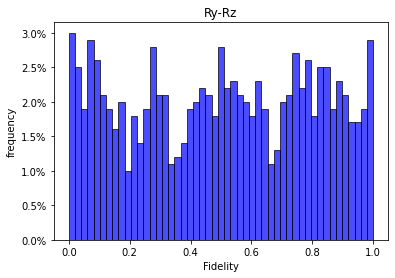

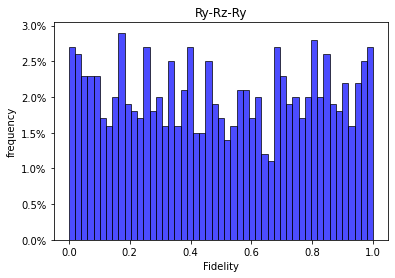

In [5]:
# evaluate the probability distribution of F generated by QNNs
def p_F_qnn(n, s, g, b=50, draw=False):
    f_list = list()
    rho_sample = outputs_y
    title_str = "Ry"
    if g == 2:
        rho_sample = outputs_yz
        title_str = "Ry-Rz"
    elif g == 3:
        rho_sample = outputs_yzy
        title_str = "Ry-Rz-Ry"
    # use previously collected data to compute fidelity
    for index in range(int(s / 2)):
        rho1 = rho_sample[index]
        rho2 = rho_sample[index+int(num_sample / 2)]
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    # plot histgram
    if draw:
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution
    
    
num_qubit = 1
p_y = p_F_qnn(num_qubit, num_sample, 1, draw=True)
p_yz = p_F_qnn(num_qubit, num_sample, 2, draw=True)
p_yzy = p_F_qnn(num_qubit, num_sample, 3, draw=True)

Evidently, the fidelity distribution of the outputs of the neural network composed of $R_Y-R_Z-R_Y$ gates is closest to that of the Haar random unitary. The K-L divergence (also called relative entropy) in statistical mathematics can measure the difference between two probability distributions. The K-L divergence between two discrete probability distributions $P,Q$ is defined as
$$
D_{KL}(P||Q)=\sum_jP(j)\ln\frac{P(j)}{Q(j)}.\tag{6}
$$
If the fidelity distribution of the outputs of a quantum neural network is denoted as $P_\text{QNN}(f)$, the expressibility of the quantum neural network is defined as the K-L divergence between $P_\text{QNN}(f)$ and $P_\text{Haar}(f)$ [2]
$$
\text{Expr}_\text{QNN}=D_{KL}(P_\text{QNN}(f)||P_\text{Haar}(f)).\tag{7}
$$
Therefore, the closer $P_\text{QNN}(f)$ is to $P_\text{Haar}(f)$, the smaller the $\text{Expr}$ will be (more close to 0), and the more expressive the quantum neural network will be; conversely, the larger the $\text{Expr}$ is, the less expressive the quantum neural network will be.

We can directly calculate the expressibility of single-qubit quantum neural networks $R_Y(\theta)$, $R_Y(\theta_1)R_Z(\theta_2)$ and $R_Y(\theta_1)R_Z(\theta_2)R_Y(\theta_3)$ according to this definition.

In [6]:
from scipy.stats import entropy
# calcutale relative entropy (K-L divergence)
expr_y = entropy(p_y, theory_haar_1qubit)
expr_yz = entropy(p_yz, theory_haar_1qubit)
expr_yzy = entropy(p_yzy, theory_haar_1qubit)
print("The expressiblity of Ry, Ry-Rz, and Ry-Rz-Rz are %.2f, %.2f, and %.2f, respectively." %(expr_y, expr_yz, expr_yzy))

The expressiblity of Ry, Ry-Rz, and Ry-Rz-Rz are 0.21, 0.03, and 0.02, respectively.


###   Evaluate the expressibility of QNNs

We now have our tool, the K-L divergence, to quantitatively study the expressibility of any quantum neural network ansatz. As a practical application, let us explore the variation of the expressibility of a Paddle Quantum QNN tamplate with different circuit depth. Here we set the width of the circuit to 4-qubit.

F generated by a Haar random unitaty：


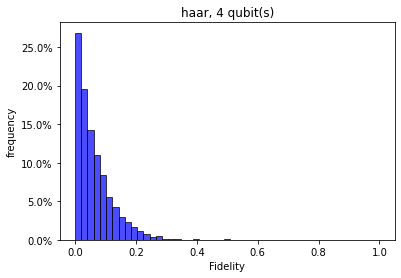

sampling QNNs with depth 1...
   sampling 0-th sample...
   sampling 400-th sample...
   sampling 800-th sample...
   sampling 1200-th sample...
   sampling 1600-th sample...
   sample finished


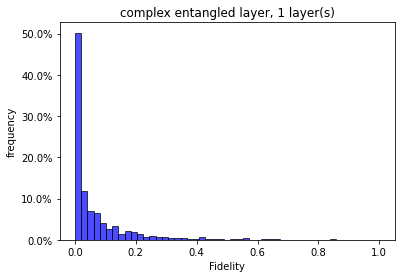

sampling QNNs with depth 2...
   sampling 0-th sample...
   sampling 400-th sample...
   sampling 800-th sample...
   sampling 1200-th sample...
   sampling 1600-th sample...
   sample finished


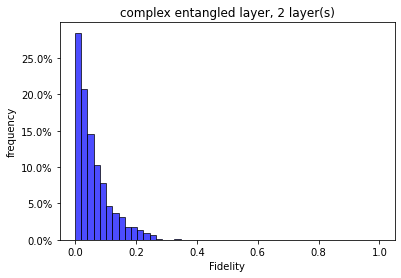

sampling QNNs with depth 3...
   sampling 0-th sample...
   sampling 400-th sample...
   sampling 800-th sample...
   sampling 1200-th sample...
   sampling 1600-th sample...
   sample finished


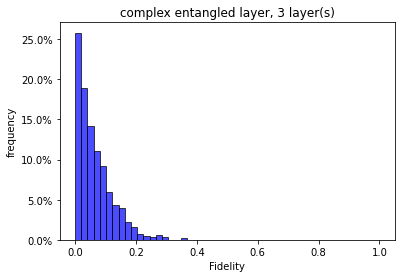

The expressibility of depth 1, 2 and 3 is [0.3136 0.0122 0.0097]


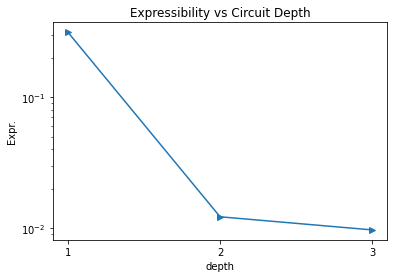

In [7]:
# evaluate the probability distribution of F generated by the complex entangled QNN
def p_F_cel(n, d, s, b=50, draw=False):
    pq.set_backend('state_vector')
    f_list = list()
    for index in range(int(s / 2)):
        if 2 * index % 400 == 0:
            print("   sampling %d-th sample..." % (2 * index))
        cir1 = Circuit(n)
        # add complex entangled layers
        cir1.complex_entangled_layer('full', d)
        # output a state vector
        rho1 = cir1(pq.state.zero_state(n))
        
        cir2 = Circuit(n)
        # add complex entangled layers
        cir2.complex_entangled_layer('full', d)
        # output another state vector
        rho2 = cir2(pq.state.zero_state(n))
        
        # calculate fidelity
        f_list.append(abs(np.inner(rho1.data.numpy(), rho2.data.numpy().conj()))**2)
        
    print("   sample finished")
    f_list = np.array(f_list)
    # plot histgram
    if draw:
        title_str = "complex entangled layer, %d layer(s)" % d
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution


# set the width and maximal depth 
num_qubit = 4
max_depth = 3
# evaluate the probability distribution of F generated by a Haar random unitaty
print("F generated by a Haar random unitaty：")
p_haar_4qubit, theory_haar_4qubit = p_F_haar(num_qubit, num_sample, draw=True)
Expr_cel = list()
# evaluate the expressibility of QNNs with different depth
for DEPTH in range(1, max_depth + 1):
    print("sampling QNNs with depth %d..." % DEPTH)
    p_cel = p_F_cel(num_qubit, DEPTH, num_sample, draw=True)
    expr = entropy(p_cel, theory_haar_4qubit)
    Expr_cel.append(expr)
# compare the expressibility
print("The expressibility of depth 1, 2 and 3 is", np.around(Expr_cel, decimals=4))
plt.plot(range(1, max_depth + 1), Expr_cel, marker='>')
plt.xlabel("depth")
plt.yscale('log')
plt.ylabel("Expr.")
plt.xticks(range(1, max_depth + 1))
plt.title("Expressibility vs Circuit Depth")
plt.show()

As we would observe, the expressibility of the quantum neural network is gradually enhanced with the increase of circuit depth. Interested readers are welcome to try to evaluate the expressibility of other Paddle Quantum QNN templates, and compare the difference in expressibility between different templates.

_______

## References

[1] Nielsen, Michael A., and Isaac L. Chuang. "Quantum Computation and Quantum Information." Cambridge University Press, 2010.

[2] Sim, Sukin, Peter D. Johnson, and Alán Aspuru‐Guzik. "Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum‐classical algorithms." [Advanced Quantum Technologies 2.12 (2019): 1900070](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070).